In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
healthy = pd.read_csv("/mnt/c/Users/donna/Downloads/Thesis/rankjes/abscor_ranks_per_feature/cov_spread_rank_results.csv")
cancer = pd.read_csv("/mnt/c/Users/donna/Downloads/Thesis/rankjes/coad_cov_spread_ranks.csv")

In [3]:
ctype = 'coad'

In [4]:
healthy['group'] = 'healthy'
cancer['group'] = ctype
df = pd.concat([healthy, cancer])

In [5]:
def fix_cell_type_suffix(cell_name):
    parts = cell_name.split('_')
    if len(parts) > 1:
        parts[-1] = parts[-1].lower()
    return '_'.join(parts)

In [6]:
##Voor scRNA
paper = pd.read_excel("/mnt/c/Users/donna/Downloads/Thesis/rankjes/paper_data.xlsx")
paper["cell_type_clean"] = paper["cell_type"].apply(fix_cell_type_suffix)

In [ ]:
###Voor scRNA data
results = [] 
for cell_type in df['cell_type'].unique():
    # Group per cell type and condition
    group1 = df[(df['cell_type'] == cell_type) & (df['group'] == 'healthy')]['rank']
    group2 = df[(df['cell_type'] == cell_type) & (df['group'] == ctype)]['rank']
    
    if len(group1) < 2 or len(group2) < 2:
        print(f"{cell_type} heeft te klein groepje")
        continue

    # Wilcoxon rank-sum test
    stat, pval = ranksums(group2, group1)

    # Fold change and effect size
    fc = np.mean(group2) / np.mean(group1) if np.mean(group1) > 0 else np.nan
    log2fc = np.log2(fc) if fc > 0 else np.nan
    effect_size = (np.mean(group2) - np.mean(group1)) / np.mean(group2) if np.mean(group2) > 0 else np.nan

    # Lookup compartment from paper
    comp_row = paper[paper["cell_type_clean"] == cell_type]
    compartment = comp_row["compartment"].values[0] if not comp_row.empty else "unknown"

    results.append({
        'cell_type': cell_type,
        'log2FC': log2fc,
        'pval': pval,
        'mean_healthy': np.mean(group1),
        'mean_cancer': np.mean(group2),
        'fc': fc,
        'effect_size': effect_size,
        'compartment': compartment
    })

# Final result DataFrame
res_df = pd.DataFrame(results)
res_df['fdr'] = multipletests(res_df['pval'], method='fdr_bh')[1]
res_df['neglog10_pval'] = -np.log10(res_df['pval'])

In [ ]:
##Voor atac
results = []

for cell_type in df['cell_type'].unique():
    # Group per cell type and condition
    group1 = df[(df['cell_type'] == cell_type) & (df['group'] == 'healthy')]['rank']
    group2 = df[(df['cell_type'] == cell_type) & (df['group'] == ctype)]['rank']
    
    if len(group1) < 2 or len(group2) < 2:
        print(f"{cell_type} heeft te klein groepje")
        continue

    # Rank-sum test
    stat, pval = ranksums(group2, group1)

    # Fold change (mean cancer / mean healthy)
    fc = np.mean(group2) / np.mean(group1) if np.mean(group1) > 0 else np.nan
    log2fc = np.log2(fc) if fc > 0 else np.nan

    # Effect size
    effect_size = (np.mean(group2) - np.mean(group1)) / np.mean(group2) if np.mean(group2) > 0 else np.nan

    # Get compartment directly from the CSV (assuming it's the same for all entries of this cell type)
    compartment = df[df['cell_type'] == cell_type]['cell_type_group'].mode().values[0] if 'cell_type_group' in df.columns else 'unknown'

    results.append({
        'cell_type': cell_type,
        'log2FC': log2fc,
        'pval': pval,
        'mean_healthy': np.mean(group1),
        'mean_cancer': np.mean(group2),
        'fc': fc,
        'effect_size': effect_size,
        'compartment': compartment
    })

res_df = pd.DataFrame(results)
res_df["cell_type"] = res_df["cell_type"].str.replace(r"[ ,\-]+", "_", regex=True)


In [8]:
res_df

,cell_type,log2FC,pval,mean_healthy,mean_cancer,fc,effect_size,compartment,FDR,FDR_reject,significant,fdr,neglog10_pval
0,B_cell_bladder,0.082466,0.140953,202.4375,214.346154,1.058826,0.055558,Immune,False,0.289987,True,0.289987,0.850924
1,T_cell_bladder,0.217940,0.000952,151.1250,175.769231,1.163072,0.140208,Immune,True,0.012034,False,0.012034,3.021301
2,bladder_urothelial_cell_bladder,0.341606,0.118674,68.4750,86.769231,1.267167,0.210838,Stromal,False,0.264592,True,0.264592,0.925645
3,capillary_endothelial_cell_bladder,-0.371502,0.005961,182.2125,140.846154,0.772977,-0.293699,Endothelial,True,0.038509,False,0.038509,2.224672
4,endothelial_cell_of_lymphatic_vessel_bladder,-0.173206,0.007858,251.0125,222.615385,0.886870,-0.127561,Endothelial,True,0.044527,False,0.044527,2.104708
...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,mast_cell_vasculature,0.040054,0.537365,112.3000,115.461538,1.028153,0.027382,Immune,False,0.688765,True,0.688765,0.269731
319,mature_NK_T_cell_vasculature,0.265845,0.003726,175.8750,211.461538,1.202340,0.168288,Immune,True,0.026747,False,0.026747,2.428714
320,pericyte_vasculature,-0.042020,0.303948,265.3875,257.769231,0.971294,-0.029555,Stromal,False,0.478903,True,0.478903,0.517201
321,plasma_cell_vasculature,0.104357,0.032916,247.9750,266.576923,1.075015,0.069781,Immune,False,0.116833,True,0.116833,1.482597


In [9]:
color_map = {'Up': '#1f77b4',     
             'Down': '#ff7f0e',    
             'Not Sig': '#999999'}  

marker_map = {
    "Immune": "o",
    "Epithelial": "s",
    "Endothelial": "D",
    "Stromal": "^",
    "unknown": "X"  
}

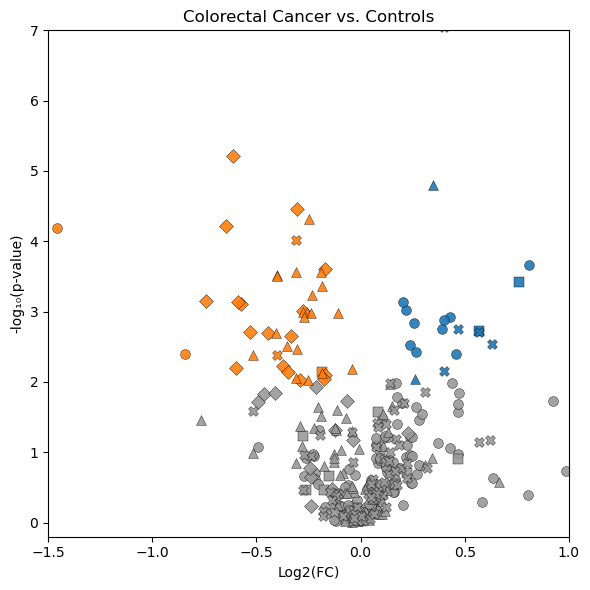

In [12]:
def label_direction(row):
    if row['fdr'] > 0.05:
        return 'Not Sig'
    elif row['log2FC'] > 0:
        return 'Up'
    else:
        return 'Down'

res_df['neglog10_pval'] = -np.log10(res_df['pval'])
res_df['fdr'] = multipletests(res_df['pval'], method='fdr_bh')[1]
res_df['direction'] = res_df.apply(label_direction, axis=1)

fig, ax = plt.subplots(figsize=(6, 6))

# Plot data points
for compartment, marker in marker_map.items():
    for direction, color in color_map.items():
        sub = res_df[(res_df["compartment"] == compartment) & (res_df["direction"] == direction)]
        if sub.empty:
            continue
        ax.scatter(
            sub['log2FC'],
            sub['neglog10_pval'],
            color=color,
            marker=marker,
            s=50,
            edgecolor='black',
            linewidth=0.3,
            alpha=0.9
        )

# Axis labels and title
ax.set_xlabel("Log2(FC)")
ax.set_ylabel("-log₁₀(p-value)")
ax.set_title("Colorectal Cancer vs. Controls")

# Set fixed axis limits
ax.set_xlim(-1.5, 1)
ax.set_ylim(-0.2, 7)
# ax.axvline(x=-0.269842383, color='black', linestyle='--', linewidth=1)
# ax.axhline(y=2.930995319, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
# plt.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/scrna_vulcano_coad.png", dpi=600, bbox_inches='tight')
plt.show()


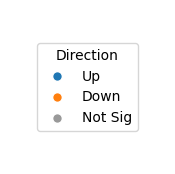

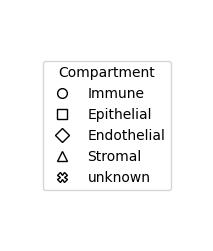

In [11]:
##VULCANO LEGENDS

from matplotlib.lines import Line2D

# Create legend handles
legend_elements_color = [
    Line2D([0], [0], marker='o', color='w', label='Up', markerfacecolor=color_map['Up'], markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Down', markerfacecolor=color_map['Down'], markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Not Sig', markerfacecolor=color_map['Not Sig'], markersize=7)
]

legend_elements_shape = [
    Line2D([0], [0], marker=marker_map[c], color='black', label=c, linestyle='None', markersize=7, markerfacecolor='white')
    for c in marker_map
]

# Plot and save color legend
fig_color = plt.figure(figsize=(2, 2))
ax_color = fig_color.add_subplot(111)
ax_color.axis('off')
legend = ax_color.legend(handles=legend_elements_color, title="Direction", loc='center')
fig_color.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/legend_direction.png", dpi=600, bbox_inches='tight')
plt.show()

# Plot and save shape legend
fig_shape = plt.figure(figsize=(2.5, 3))
ax_shape = fig_shape.add_subplot(111)
ax_shape.axis('off')
legend = ax_shape.legend(handles=legend_elements_shape, title="Compartment", loc='center')
fig_shape.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/legend_compartment.png", dpi=600, bbox_inches='tight')
plt.show()

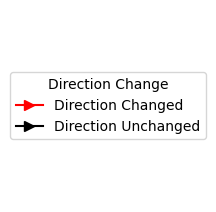

In [56]:
# Arrow direction change legend
legend_elements_arrow = [
    Line2D([0], [0], color='red', linestyle='-', marker='>', label='Direction Changed', markersize=7),
    Line2D([0], [0], color='black', linestyle='-', marker='>', label='Direction Unchanged', markersize=7)
]

fig_arrow = plt.figure(figsize=(2.5, 2.5))
ax_arrow = fig_arrow.add_subplot(111)
ax_arrow.axis('off')
legend = ax_arrow.legend(handles=legend_elements_arrow, title="Direction Change", loc='center')
fig_arrow.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/legend_direction_change.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
## ZONDER LEGENDAS
color_map = {'Up': '#1f77b4',
             'Down': '#ff7f0e',
             'Not Sig': '#999999'}

marker_map = {
    "Immune": "o",
    "Epithelial": "s",
    "Endothelial": "D",
    "Stromal": "^",
    "unknown": "X"
}

def label_direction(row):
    if row['fdr'] > 0.05:
        return 'Not Sig'
    elif row['log2FC'] > 0:
        return 'Up'
    else:
        return 'Down'

res_df['neglog10_pval'] = -np.log10(res_df['pval'])
res_df['fdr'] = multipletests(res_df['pval'], method='fdr_bh')[1]
res_df['direction'] = res_df.apply(label_direction, axis=1)

fig, ax = plt.subplots(figsize=(6, 6))

# Plot data points without legends
for compartment, marker in marker_map.items():
    for direction, color in color_map.items():
        sub = res_df[(res_df["compartment"] == compartment) & (res_df["direction"] == direction)]
        if sub.empty:
            continue
        ax.scatter(
            sub['log2FC'],
            sub['neglog10_pval'],
            color=color,
            marker=marker,
            s=50,
            edgecolor='black',
            linewidth=0.3,
            alpha=0.9
        )

# Axis labels and title
ax.set_xlabel("Log2(FC)")
ax.set_ylabel("-log₁₀(p-value)")
ax.set_title("Breast Cancer vs. Controls")

plt.tight_layout()
plt.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/atac_volcano_brca.png", dpi=600, bbox_inches='tight')
plt.show()


In [115]:
res_df[['cell_type', 'compartment', 'log2FC', 'pval', 'fdr', 'direction']].to_csv(
    "/mnt/c/Users/donna/Downloads/Thesis/tacje/scrna_volcano_celltypes_coad.csv",
    index=False
)

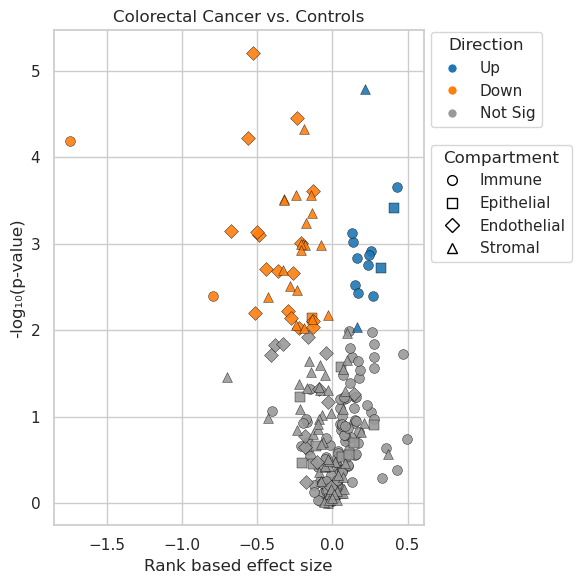

In [181]:
color_map = {'Up': '#1f77b4',     
             'Down': '#ff7f0e',    
             'Not Sig': '#999999'}  

marker_map = {
    "Immune": "o",
    "Epithelial": "s",
    "Endothelial": "D",
    "Stromal": "^"
}

def label_direction(row):
    if row['fdr'] > 0.05:
        return 'Not Sig'
    elif row['effect_size'] > 0:
        return 'Up'
    else:
        return 'Down'

res_df['neglog10_pval'] = -np.log10(res_df['pval'])
res_df['fdr'] = multipletests(res_df['pval'], method='fdr_bh')[1]
res_df['direction'] = res_df.apply(label_direction, axis=1)


fig, ax = plt.subplots(figsize=(6, 6))

# Plot without auto legend
for compartment, marker in marker_map.items():
    for direction, color in color_map.items():
        sub = res_df[(res_df["compartment"] == compartment) & (res_df["direction"] == direction)]
        if sub.empty:
            continue
        ax.scatter(
            sub['effect_size'],
            sub['neglog10_pval'],
            color=color,
            marker=marker,
            s=50,
            edgecolor='black',
            linewidth=0.3,
            alpha=0.9
        )

# Axis labels and decorations
ax.set_xlabel("Rank based effect size")
ax.set_ylabel("-log₁₀(p-value)")
ax.set_title("Colorectal Cancer vs. Controls")

#Color legend
legend_elements_color = [
    Line2D([0], [0], marker='o', color='w', label='Up', markerfacecolor=color_map['Up'], markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Down', markerfacecolor=color_map['Down'], markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Not Sig', markerfacecolor=color_map['Not Sig'], markersize=7)
]

#Shapes legend
legend_elements_shape = [
    Line2D([0], [0], marker=marker_map[c], color='black', label=c, linestyle='None', markersize=7, markerfacecolor='white')
    for c in marker_map
]

#legend psoitioninf
legend1 = ax.legend(handles=legend_elements_color, title="Direction", loc='center left', bbox_to_anchor=(1.02, 0.9), borderaxespad=0)
legend2 = ax.legend(handles=legend_elements_shape, title="Compartment", loc='center left', bbox_to_anchor=(1.02, 0.65), borderaxespad=0)
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/effectsize_volcano_coad.png", dpi=600, bbox_inches='tight')
plt.show()